In [3]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path import join
from PIL import Image

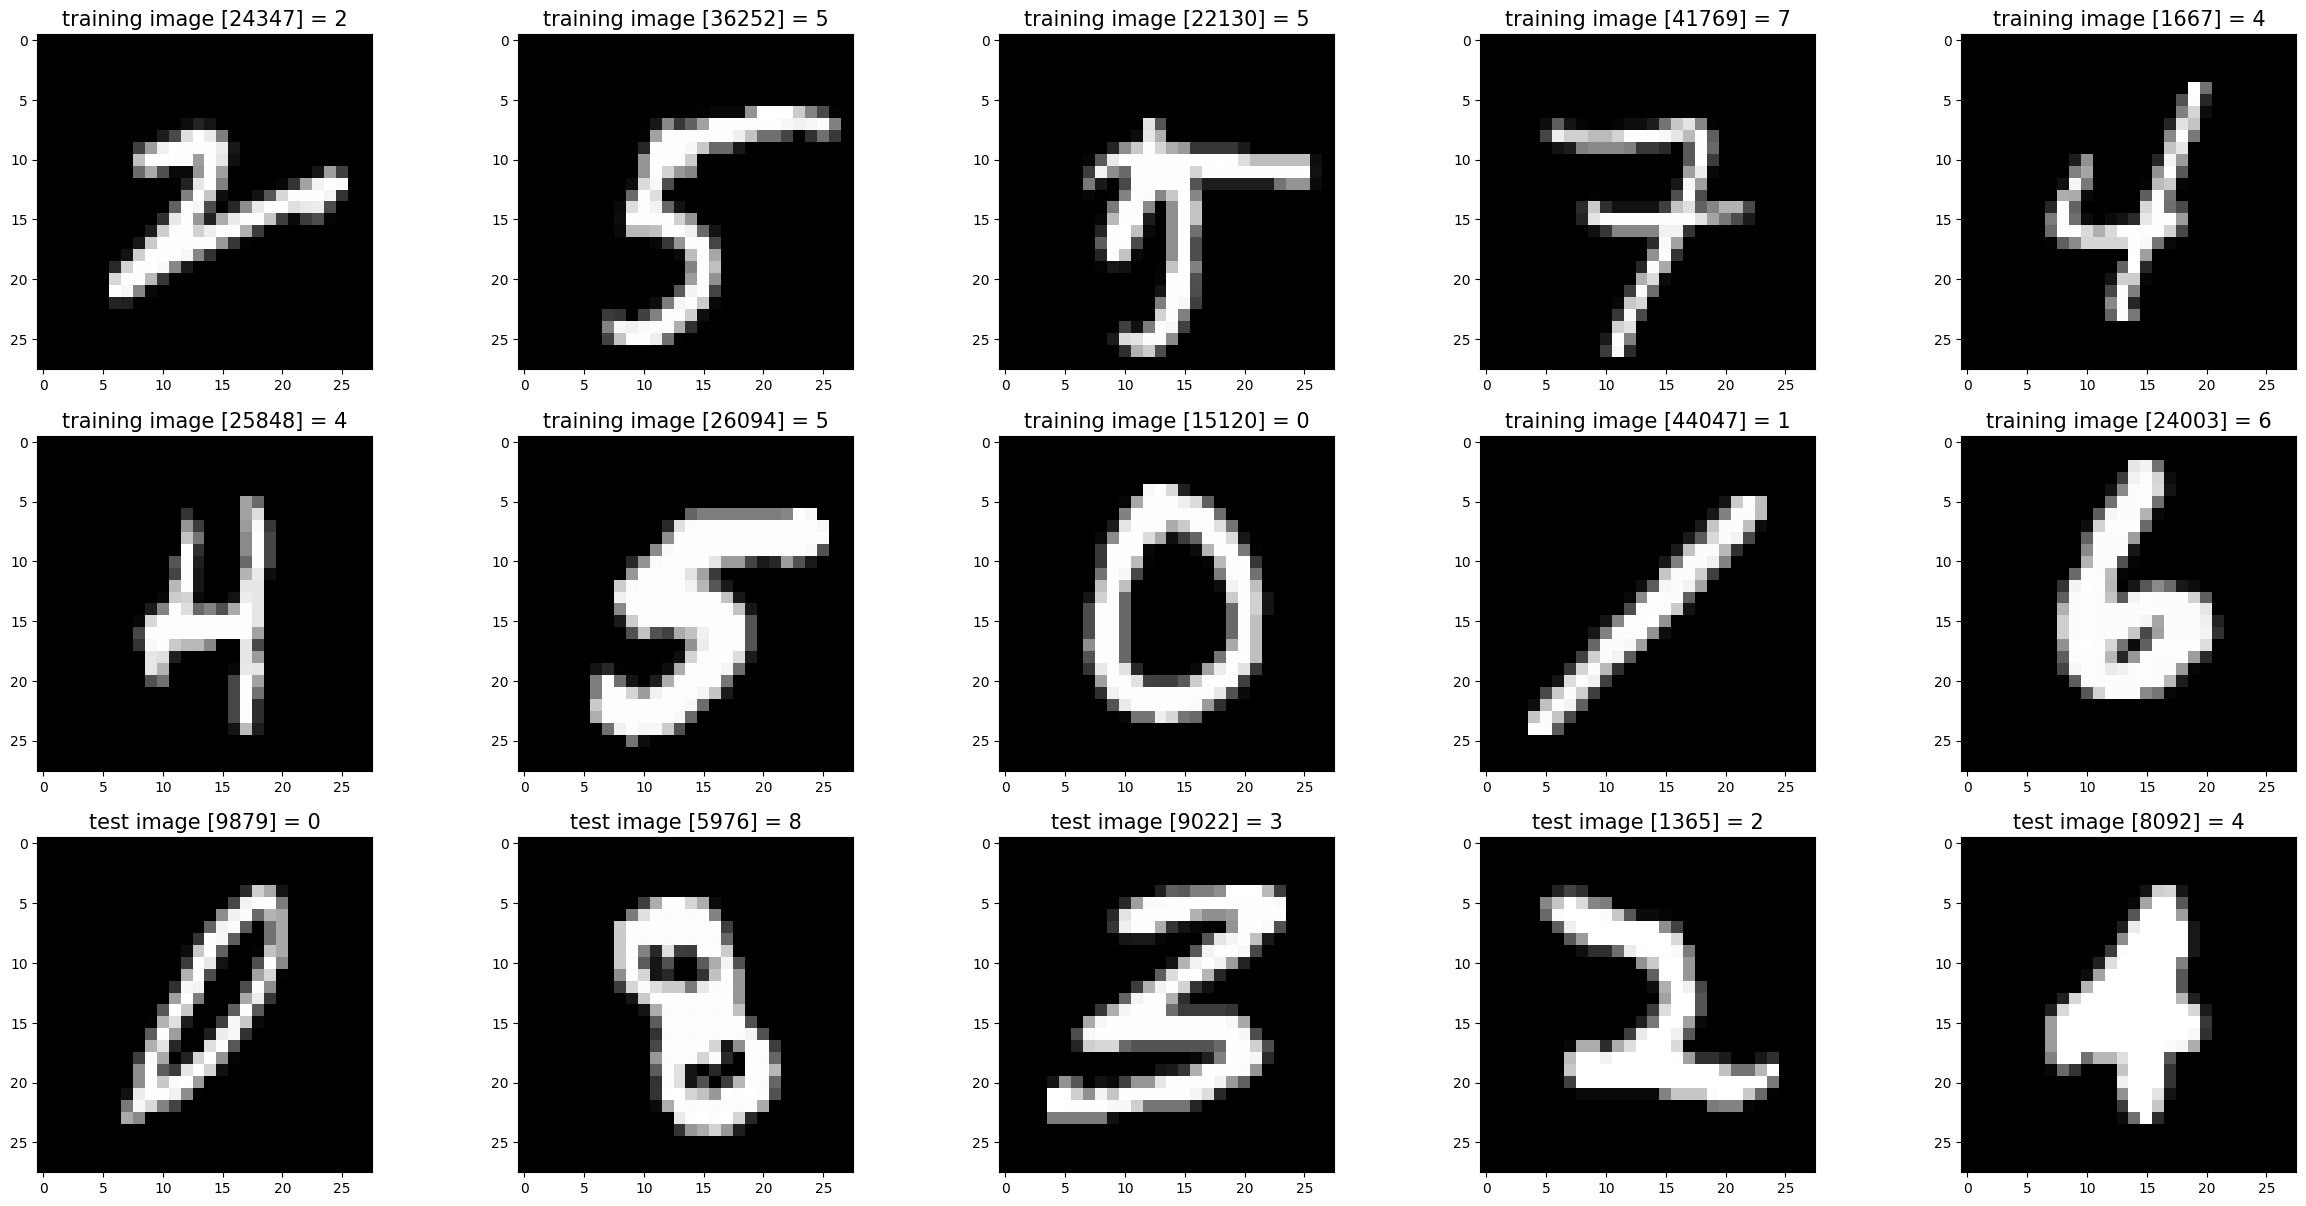

In [4]:

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on MNIST Datasets in mnist folder
#
input_path = './mnist'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)


In [5]:

#
# Memory-efficient: Load and save images directly from MNIST files without storing all in RAM
# Using PIL for efficient image I/O instead of matplotlib
#
import os
import shutil

# Create main results folder
results_folder = './results'

# Remove existing results folder to start fresh
if os.path.exists(results_folder):
    shutil.rmtree(results_folder)
    print(f"Removed existing '{results_folder}' folder")

os.makedirs(results_folder, exist_ok=True)

# Create 10 subfolders for digits 0-9
for digit in range(10):
    digit_folder = os.path.join(results_folder, str(digit))
    os.makedirs(digit_folder, exist_ok=True)

print(f"Created digit folders 0-9 in '{results_folder}'")

def load_and_save_mnist_streaming(images_filepath, labels_filepath, dataset_name):
    """Load MNIST files and save images on-the-fly using PIL (memory efficient)"""
    
    # Load labels
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError(f'Magic number mismatch, expected 2049, got {magic}')
        labels_data = array("B", file.read())
    
    # Load and process images one by one
    with open(images_filepath, 'rb') as file:
        magic, num_images, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError(f'Magic number mismatch, expected 2051, got {magic}')
        
        print(f"\nSaving {dataset_name} images ({num_images} total)...")
        
        for i in range(num_images):
            # Read single image (28x28 = 784 bytes)
            image_data = array("B", file.read(rows * cols))
            img_array = np.array(image_data, dtype=np.uint8).reshape(rows, cols)
            
            # Convert to PIL Image and save directly (no matplotlib overhead)
            img = Image.fromarray(img_array, mode='L')  # 'L' = grayscale
            
            label = labels_data[i]
            digit_folder = os.path.join(results_folder, str(label))
            filename = os.path.join(digit_folder, f'{dataset_name}_{i:05d}.png')
            
            # Save as PNG - PIL is much more efficient than plt.savefig
            img.save(filename)
            
            if (i + 1) % 10000 == 0:
                print(f"  Progress: {i + 1}/{num_images} {dataset_name} images saved")
        
        return num_images

# Process training and test data
total_train = load_and_save_mnist_streaming(training_images_filepath, training_labels_filepath, 'train')
total_test = load_and_save_mnist_streaming(test_images_filepath, test_labels_filepath, 'test')

# Print summary statistics
print(f"\n✓ All images saved to '{results_folder}' folder")
print(f"✓ Total images saved: {total_train + total_test} ({total_train} training + {total_test} test)")
print(f"\nFolder structure:")
for digit in range(10):
    digit_folder = os.path.join(results_folder, str(digit))
    image_count = len([f for f in os.listdir(digit_folder) if f.endswith('.png')])
    print(f"  {results_folder}/{digit}/ -> {image_count} images")


Removed existing './results' folder
Created digit folders 0-9 in './results'

Saving train images (60000 total)...
  Progress: 10000/60000 train images saved
  Progress: 10000/60000 train images saved
  Progress: 20000/60000 train images saved
  Progress: 20000/60000 train images saved
  Progress: 30000/60000 train images saved
  Progress: 30000/60000 train images saved
  Progress: 40000/60000 train images saved
  Progress: 40000/60000 train images saved
  Progress: 50000/60000 train images saved
  Progress: 50000/60000 train images saved
  Progress: 60000/60000 train images saved

Saving test images (10000 total)...
  Progress: 60000/60000 train images saved

Saving test images (10000 total)...
  Progress: 10000/10000 test images saved

✓ All images saved to './results' folder
✓ Total images saved: 70000 (60000 training + 10000 test)

Folder structure:
  ./results/0/ -> 6903 images
  ./results/1/ -> 7877 images
  ./results/2/ -> 6990 images
  ./results/3/ -> 7141 images
  ./results/4/

In [6]:

# Clear large data from memory to free up RAM
del x_train, x_test, y_train, y_test, images_2_show, titles_2_show
import gc
gc.collect()
print("Cleared MNIST data from memory")


Cleared MNIST data from memory


In [6]:

#
# Check dataset sizes
#
print(f"Training images count: {len(x_train)}")
print(f"Test images count: {len(x_test)}")
print(f"Total images: {len(x_train) + len(x_test)}")


Training images count: 60000
Test images count: 10000
Total images: 70000
